In [1]:
import os
import pandas as pd
from Bio.SeqUtils import GC
import gzip
import glob
from sklearn.model_selection import train_test_split
from Bio import SeqIO
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize
import numpy as np

Carregar tabela com metedados dos genomas disponíveis no Ref-Seq

In [2]:
from refsef_download import carregar_metadados

In [3]:
refseq_metadados = carregar_metadados("prokaryotes.xlsx")

In [4]:
print(f"Total de genomas: {len(refseq_metadados)}")

Total de genomas: 409473


Limpeza dos dados

In [5]:
#Deletar exemplos com dados faltantes
refseq_metadados.dropna(inplace = True)

In [6]:
#Manter genomas com rRNA disponíveis
refseq_metadados = refseq_metadados[refseq_metadados.rRNA > 0]
print(f"Número de genomas com RNA ribossomal: {len(refseq_metadados)}")

Número de genomas com RNA ribossomal: 252823


Baixar genomas (pode levar algum tempo)

In [7]:
from refsef_download import baixar_genomas

In [8]:
sufix = "_rna_from_genomic.fna.gz"
genomas_max = 500
for info in refseq_metadados[0:genomas_max].itertuples():
    genome_id = info.FTP_refseq.split("/")[-1]
    os.system(f"wget {info.FTP_refseq + '/' + genome_id + sufix} -O data/{genome_id}-{info.Taxon.split(';')[-1]}.fasta.gz")            


In [9]:
rnas = glob.glob("data/*.gz")

In [11]:
from Bio import SeqIO
genomas_com_23S = []
genomas_com_16S = []
for arquivo in rnas:
    #print(arquivo)
    with gzip.open(arquivo,"rt") as fasta:
        for info23 in SeqIO.parse(fasta,"fasta"):
            if "product=23S " in info23.description:
                genomas_com_23S.append(arquivo)
                break
        for info16 in SeqIO.parse(fasta,"fasta"):
            if "product=16S" in info16.description:
                genomas_com_16S.append(arquivo)
                break
rnas = list(set(genomas_com_16S) & set(genomas_com_23S))


In [13]:
with open("dataset16s.fasta","w+") as file:
    for arquivo in rnas:
        with gzip.open(arquivo,"rt") as fasta:
            for info in SeqIO.parse(fasta,"fasta"):
                if "16S" in info.description:
                    genome_id = arquivo.split("/")[-1].split("_r")[0]
                    file.write(f">{genome_id}\n")
                    file.write(f"{info.seq}\n")
                    break           

In [14]:
with open("dataset23s.fasta","w+") as file:
    for arquivo in rnas:
        with gzip.open(arquivo,"rt") as fasta:
            for info in SeqIO.parse(fasta,"fasta"):
                if "23S" in info.description:
                    genome_id = arquivo.split("/")[-1].split("_r")[0]
                    file.write(f">{genome_id}\n")
                    file.write(f"{info.seq}\n")
                    break         

In [15]:
z23 = []
ids_23 = []
conteudo_gc_23 = []
for seq_record in SeqIO.parse("/home/tiago/documents/projeto_iam/dataset23s.fasta","fasta"):
    ids_23.append(seq_record.id)
    conteudo_gc_23.append(GC(seq_record.seq))
    A = str(seq_record.seq).count("A")
    T = str(seq_record.seq).count("T")
    C = str(seq_record.seq).count("C")
    G = str(seq_record.seq).count("G")
    xn = (A+G) - (C+T)
    yn = (A+C) - (G+T)
    zn = (A+T) - (C+G)
    z23.append([zn,yn,zn])



z16 = []
ids_16 = []
conteudo_gc_16 = []
for seq_record in SeqIO.parse("/home/tiago/documents/projeto_iam/dataset16s.fasta","fasta"):
    ids_16.append(seq_record.id)
    conteudo_gc_16.append(GC(seq_record.seq))
    A = str(seq_record.seq).count("A")
    T = str(seq_record.seq).count("T")
    C = str(seq_record.seq).count("C")
    G = str(seq_record.seq).count("G")
    xn = (A+G) - (C+T)
    yn = (A+C) - (G+T)
    zn=  (A+T) - (C+G)
    z16.append([xn,yn,zn])
    
classes = [x.split('-')[-1].split('.')[0] for x in ids_16]
    

In [17]:
ids_23 == ids_16

True

In [18]:
features = pd.DataFrame({
    "Genome":ids_16,
    "ZCurve_16S":z16,
    "GC_16S":conteudo_gc_16,
    "ZCurve_23S":z23,
    "GC_23S":conteudo_gc_23,
    "Classes":classes
    })
features.head()

,Genome,ZCurve_16S,GC_16S,ZCurve_23S,GC_23S,Classes
0,GCF_900101795.1_IMG-taxon_2693429822_annotated...,"[221, -59, -195]",56.360078,"[-198, -108, -198]",53.435115,Betaproteobacteria
1,GCF_000174355.1_ASM17435v1-Betaproteobacteria....,"[212, -58, -170]",55.533854,"[-31, -25, -31]",55.218855,Betaproteobacteria
2,GCF_020171845.1_ASM2017184v1-Firmicutes.fasta.gz,"[31, -9, 5]",48.826291,"[5, -3, 5]",48.878924,Firmicutes
3,GCF_001296225.1_ASM129622v1-Gammaproteobacteri...,"[7, -5, -7]",55.384615,"[-69, -135, -69]",51.200835,Gammaproteobacteria
4,GCF_002504285.1_ASM250428v1-Gammaproteobacteri...,"[214, -66, -120]",53.886010,"[-159, -127, -159]",52.734778,Gammaproteobacteria


In [21]:
classes = list(set(features.Classes.values))
codificador_classes = LabelEncoder()
codificador_classes.fit(classes)
features["y"] = codificador_classes.transform(features.Classes)
features["X"] = [np.array([x.GC_16S,x.GC_23S]) for x in features.itertuples()]
ZC_GC = []
for i in range(len(features)):
    j = []
    j.extend(features.ZCurve_16S.values[i])
    j.extend(features.ZCurve_23S.values[i])
    j.append(features.GC_16S.values[i])
    j.append(features.GC_23S.values[i])
    ZC_GC.append(j)
features["ZC_GC"] = ZC_GC

In [22]:
features.head()

,Genome,ZCurve_16S,GC_16S,ZCurve_23S,GC_23S,Classes,y,X,ZC_GC
0,GCF_900101795.1_IMG-taxon_2693429822_annotated...,"[221, -59, -195]",56.360078,"[-198, -108, -198]",53.435115,Betaproteobacteria,7,"[56.360078277886494, 53.43511450381679]","[221, -59, -195, -198, -108, -198, 56.36007827..."
1,GCF_000174355.1_ASM17435v1-Betaproteobacteria....,"[212, -58, -170]",55.533854,"[-31, -25, -31]",55.218855,Betaproteobacteria,7,"[55.533854166666664, 55.21885521885522]","[212, -58, -170, -31, -25, -31, 55.53385416666..."
2,GCF_020171845.1_ASM2017184v1-Firmicutes.fasta.gz,"[31, -9, 5]",48.826291,"[5, -3, 5]",48.878924,Firmicutes,18,"[48.82629107981221, 48.87892376681614]","[31, -9, 5, 5, -3, 5, 48.82629107981221, 48.87..."
3,GCF_001296225.1_ASM129622v1-Gammaproteobacteri...,"[7, -5, -7]",55.384615,"[-69, -135, -69]",51.200835,Gammaproteobacteria,27,"[55.38461538461539, 51.200835363731294]","[7, -5, -7, -69, -135, -69, 55.38461538461539,..."
4,GCF_002504285.1_ASM250428v1-Gammaproteobacteri...,"[214, -66, -120]",53.886010,"[-159, -127, -159]",52.734778,Gammaproteobacteria,27,"[53.8860103626943, 52.73477812177502]","[214, -66, -120, -159, -127, -159, 53.88601036..."


In [23]:
classes_count = features.Classes.value_counts()
classes_manter = list(classes_count[classes_count > 1].index)
features = features.query("Classes == @classes_manter")
features = features.query("Classes != 'Other'")

Text(0, 0.5, 'Número de exemplos')

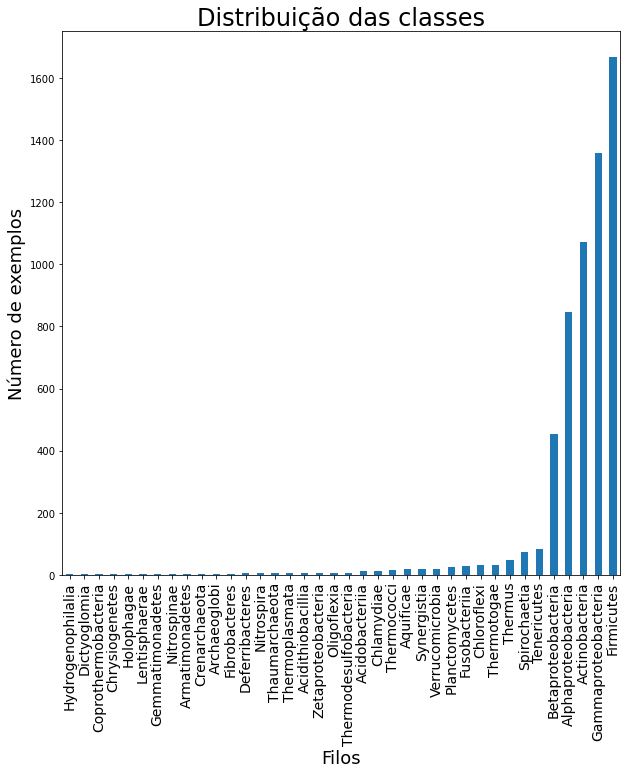

In [24]:
plt.figure(figsize = (10,10))
pd.get_dummies(features.Classes).sum().sort_values().plot.bar()
plt.title("Distribuição das classes", fontsize = 24)
plt.xlabel("Filos", fontsize = 18)
plt.xticks(fontsize = 14)
plt.ylabel("Número de exemplos", fontsize = 18)

Text(0, 0.5, 'GC% no rRNA 23S')

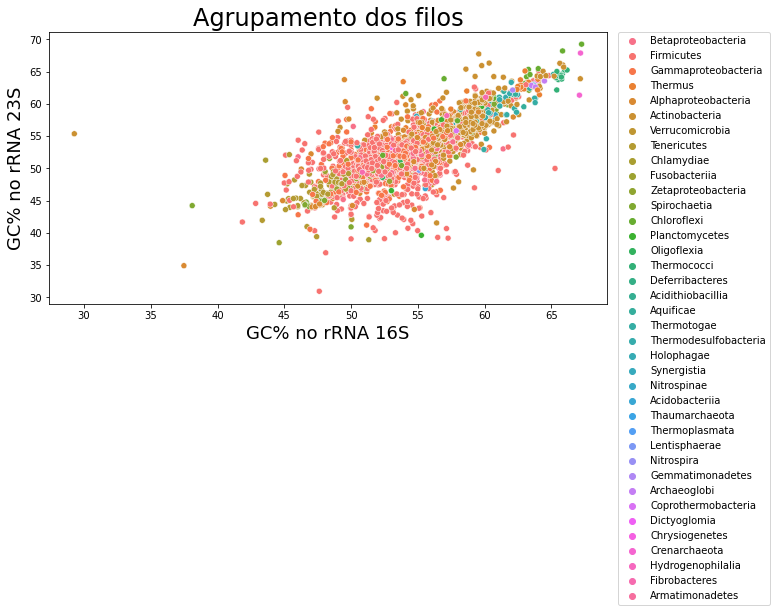

In [25]:
plt.figure(figsize = (10,5))
sns.scatterplot(data = features, x = "GC_16S", y = "GC_23S", hue = "Classes")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.title("Agrupamento dos filos",fontsize = 24)
plt.xlabel("GC% no rRNA 16S", fontsize = 18)
plt.ylabel("GC% no rRNA 23S", fontsize = 18)

Text(0, 0.5, 'GC% no rRNA 23S')

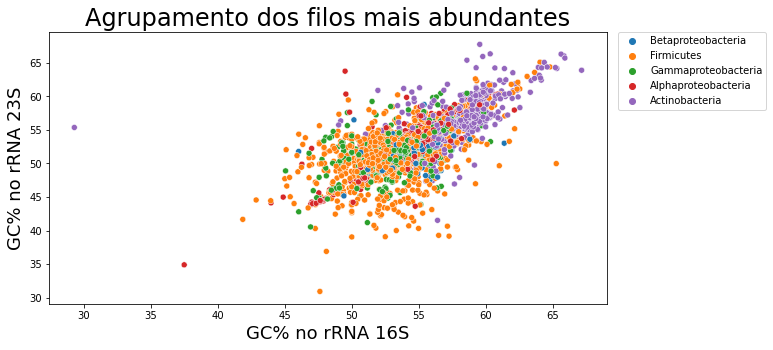

In [26]:
mais_numerosas = ["Firmicutes","Gammaproteobacteria","Actinobacteria","Alphaproteobacteria","Betaproteobacteria"]
plt.figure(figsize = (10,5))
sns.scatterplot(data = features.query("Classes == @mais_numerosas"), x = "GC_16S", y = "GC_23S", hue = "Classes")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.title("Agrupamento dos filos mais abundantes",fontsize = 24)
plt.xlabel("GC% no rRNA 16S", fontsize = 18)
plt.ylabel("GC% no rRNA 23S", fontsize = 18)

In [27]:
ZCurve_16SN_max = np.vstack(features.ZCurve_16S.values).max()
GC_16S_max = np.vstack(features.GC_16S.values).max()
ZCurve_23SN_max = np.vstack(features.ZCurve_23S.values).max()
GC_23SN_max = np.vstack(features.GC_23S.values).max()
Xn_max = np.vstack(features.X.values).max()
features["ZCurve_16SN"] = list(np.vstack(features.ZCurve_16S.values)/ZCurve_16SN_max)
features["GC_16SN"] = list(np.array(features.GC_16S.values)/GC_16S_max)
features["ZCurve_23SN"] = list(np.vstack(features.ZCurve_23S.values)/ZCurve_23SN_max)
features["GC_23SN"] = list(np.array(features.GC_23S.values)/GC_23SN_max)
features["Xn"] = list(np.vstack(features.X.values)/Xn_max)


In [28]:
ZC_GC = []
for i in range(len(features)):
    j = []
    j.extend(features.ZCurve_16SN.values[i])
    j.extend(features.ZCurve_23SN.values[i])
    j.append(features.GC_16SN.values[i])
    j.append(features.GC_23SN.values[i])
    ZC_GC.append(j)
features["ZC_GCN"] = ZC_GC

In [29]:
def knn(k, modo = "norm"):
    if modo == "norm":
        clf_knn_sklearn = neighbors.KNeighborsClassifier(k,weights = "distance")

        ### Treinamento com RNA ribossomal

        X_train_rna, X_test_rna, y_train_rna, y_test_rna = train_test_split(features.Xn.values, features.y.values, test_size=0.33, random_state=42, stratify = features.y)
        set(y_train_rna,).difference(set(y_test_rna))

        clf_rRNA = clf_knn_sklearn.fit(np.vstack(X_train_rna),y_train_rna)
        y_hat_rRNA = clf_rRNA.predict_proba(np.vstack(X_test_rna))
        roc_auc_rRNA = roc_auc_score(y_test_rna,y_hat_rRNA, multi_class = "ovr", average = "macro")
        roc_auc_rRNA

        ### Treinamento com Z Curve rRNA 16S

        X_train_ZC16, X_test_ZC16, y_train_ZC16, y_test_ZC16 = train_test_split(features.ZCurve_16SN.values, features.y.values, test_size=0.33, random_state=42, stratify = features.y)
        set(y_train_ZC16).difference(set(y_test_ZC16))

        clf_ZC16 = clf_knn_sklearn.fit(np.vstack(X_train_ZC16),y_train_ZC16)
        y_hat_ZC16 = clf_ZC16.predict_proba(np.vstack(X_test_ZC16))
        roc_auc_ZC16 =  roc_auc_score(y_test_ZC16,y_hat_ZC16, multi_class = "ovr", average = "macro")
        roc_auc_ZC16

        ### Treinamento com Z Curve rRNA 23S

        X_train_ZC23, X_test_ZC23, y_train_ZC23, y_test_ZC23 = train_test_split(features.ZCurve_23SN.values, features.y.values, test_size=0.33, random_state=42, stratify = features.y)
        set(y_train_ZC23,).difference(set(y_test_ZC23))

        clf_ZC23 = clf_knn_sklearn.fit(np.vstack(X_train_ZC23),y_train_ZC23)
        y_hat_ZC23 = clf_ZC23.predict_proba(np.vstack(X_test_ZC23))
        roc_auc_ZC23 =  roc_auc_score(y_test_ZC23,y_hat_ZC23, multi_class = "ovr", average = "macro")
        roc_auc_ZC23

        ### Treinamento com Z Curve rRNA, GC23S e GC16S

        X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(features.ZC_GCN.values, features.y.values, test_size=0.33, random_state=42, stratify = features.y)
        set(y_train_all,).difference(set(y_test_all))

        clf_all = clf_knn_sklearn.fit(np.vstack(X_train_all),y_train_all)
        y_hat_all = clf_all.predict_proba(np.vstack(X_test_all))
        roc_auc_all =  roc_auc_score(y_test_all,y_hat_all, multi_class = "ovr", average = "macro")
        roc_auc_all
        return [roc_auc_rRNA,roc_auc_ZC16,roc_auc_ZC23,roc_auc_all]
    else:
        clf_knn_sklearn = neighbors.KNeighborsClassifier(k,weights = "distance")

        ### Treinamento com RNA ribossomal

        X_train_rna, X_test_rna, y_train_rna, y_test_rna = train_test_split(features.X.values, features.y.values, test_size=0.33, random_state=42, stratify = features.y)
        set(y_train_rna,).difference(set(y_test_rna))

        clf_rRNA = clf_knn_sklearn.fit(np.vstack(X_train_rna),y_train_rna)
        y_hat_rRNA = clf_rRNA.predict_proba(np.vstack(X_test_rna))
        roc_auc_rRNA = roc_auc_score(y_test_rna,y_hat_rRNA, multi_class = "ovr", average = "macro")
        roc_auc_rRNA

        ### Treinamento com Z Curve rRNA 16S

        X_train_ZC16, X_test_ZC16, y_train_ZC16, y_test_ZC16 = train_test_split(features.ZCurve_16S.values, features.y.values, test_size=0.33, random_state=42, stratify = features.y)
        set(y_train_ZC16).difference(set(y_test_ZC16))

        clf_ZC16 = clf_knn_sklearn.fit(np.vstack(X_train_ZC16),y_train_ZC16)
        y_hat_ZC16 = clf_ZC16.predict_proba(np.vstack(X_test_ZC16))
        roc_auc_ZC16 =  roc_auc_score(y_test_ZC16,y_hat_ZC16, multi_class = "ovr", average = "macro")
        roc_auc_ZC16

        ### Treinamento com Z Curve rRNA 23S

        X_train_ZC23, X_test_ZC23, y_train_ZC23, y_test_ZC23 = train_test_split(features.ZCurve_23S.values, features.y.values, test_size=0.33, random_state=42, stratify = features.y)
        set(y_train_ZC23,).difference(set(y_test_ZC23))

        clf_ZC23 = clf_knn_sklearn.fit(np.vstack(X_train_ZC23),y_train_ZC23)
        y_hat_ZC23 = clf_ZC23.predict_proba(np.vstack(X_test_ZC23))
        roc_auc_ZC23 =  roc_auc_score(y_test_ZC23,y_hat_ZC23, multi_class = "ovr", average = "macro")
        roc_auc_ZC23

        ### Treinamento com Z Curve rRNA, GC23S e GC16S

        X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(features.ZC_GC.values, features.y.values, test_size=0.33, random_state=42, stratify = features.y)
        set(y_train_all,).difference(set(y_test_all))

        clf_all = clf_knn_sklearn.fit(np.vstack(X_train_all),y_train_all)
        y_hat_all = clf_all.predict_proba(np.vstack(X_test_all))
        roc_auc_all =  roc_auc_score(y_test_all,y_hat_all, multi_class = "ovr", average = "macro")
        roc_auc_all
        return [roc_auc_rRNA,roc_auc_ZC16,roc_auc_ZC23,roc_auc_all]


In [30]:
from sklearn import neighbors
from sklearn.metrics import roc_auc_score

In [74]:
score_list_norme = []
for i in range(5,100):
    score_list_norme.append(knn(k = i,modo = "norm"))

Text(0, 0.5, 'ROC-AUC Score')

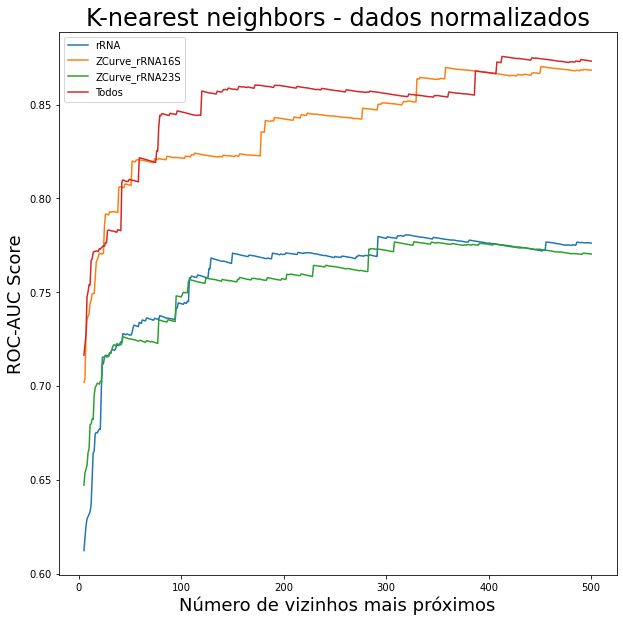

In [77]:
knn_arr = np.array(score_list_norme)
knn_table_norm = pd.DataFrame(
    knn_arr, 
    columns = ["rRNA","ZCurve_rRNA16S","ZCurve_rRNA23S","Todos"],
    index = list(range(5,501))
)

knn_table_norm.plot(figsize = (10,10))
plt.title("K-nearest neighbors - dados normalizados",fontsize = 24)
plt.xlabel("Número de vizinhos mais próximos", fontsize = 18)
plt.ylabel("ROC-AUC Score", fontsize = 18)

In [78]:
score_list = []
for i in range(5,501):
    score_list.append(knn(k = i))

Text(0, 0.5, 'ROC-AUC Score')

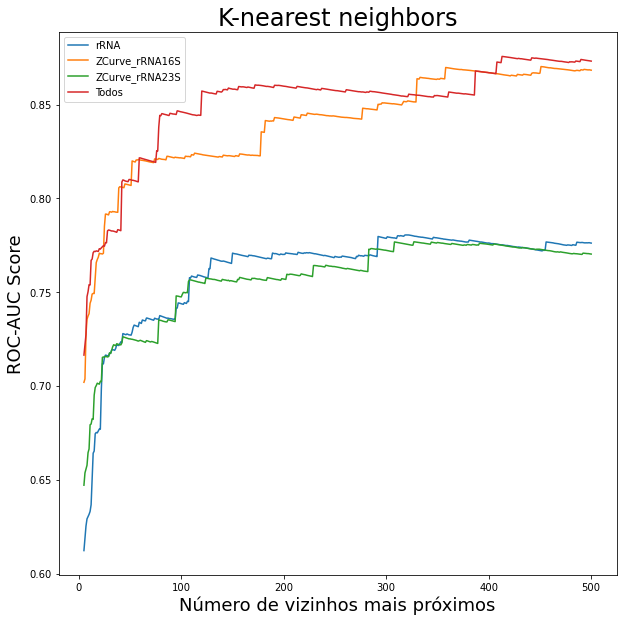

In [79]:
knn_arr = np.array(score_list)
knn_table = pd.DataFrame(
    knn_arr, 
    columns = ["rRNA","ZCurve_rRNA16S","ZCurve_rRNA23S","Todos"],
    index = list(range(5,501))
)
knn_table.plot(figsize = (10,10))
plt.title("K-nearest neighbors",fontsize = 24)
plt.xlabel("Número de vizinhos mais próximos", fontsize = 18)
plt.ylabel("ROC-AUC Score", fontsize = 18)

In [41]:
from sklearn import svm
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(features.ZC_GCN.values, features.y.values, test_size=0.33, random_state=42, stratify = features.y)
set(y_train_all,).difference(set(y_test_all))

clf_svm = svm.SVC(probability =  True)
clf_all = clf_svm.fit(np.vstack(X_train_all),y_train_all)
y_hat_all = clf_all.predict_proba(np.vstack(X_test_all))
roc_auc_all =  roc_auc_score(y_test_all,y_hat_all, multi_class = "ovr", average = "macro")
roc_auc_all

0.8666340365444537

In [31]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import cross_val_score

In [ ]:
roc_auc_list = []
for i in range(2,51):
    dt_clf = DecisionTreeClassifier(random_state=0,max_leaf_nodes = i)
    dt_clf.fit(np.vstack(X_train_all),y_train_all)
    y_hat_dt = dt_clf.predict_proba(np.vstack(X_test_all))
    roc_auc_dt =  roc_auc_score(y_test_all,y_hat_dt, multi_class = "ovr", average = "macro")
    roc_auc_list.append(roc_auc_dt)


Text(0, 0.5, 'ROC-AUC Score')

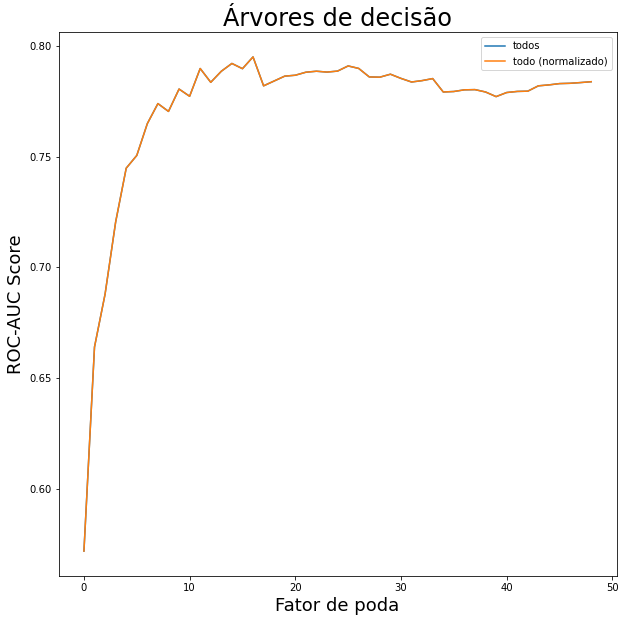

In [44]:
roc_auc_list_n = np.array(roc_auc_list_n)
dt_table = pd.DataFrame({
    "todos":roc_auc_list,
    "todos (normalizado)":roc_auc_list_n
})
dt_table.plot(figsize = (10,10))
plt.title("Árvores de decisão",fontsize = 24)
plt.xlabel("Fator de poda", fontsize = 18)
plt.ylabel("ROC-AUC Score", fontsize = 18)
